# Comparison of Image Compression Techniques
- JPEG (1992 original standard) - DCT and quantization vs. thresholding
- JPEG2000 - only look at lossy standard. DWT -> quantization -> run length encoding (not spec)
- JPEGThreshold - variant w/ thresholding
- SVD (not good)
- DWT->SVD->QUANT->IDWT (not good)
- SVD->DWT->QUANT->IDWT (same as if DWT and SVD are switched)

In [1]:
using Plots
using Plots.PlotMeasures
using LaTeXStrings
using LinearAlgebra
using FFTW
using Images
using TestImages
using Wavelets
using Colors

In [2]:
save("writeup/images/mandrill_orig.png", testimage("mandrill"))
save("writeup/images/peppers_orig.png", testimage("peppers"))
save("writeup/images/lighthouse_orig.png", testimage("lighthouse")[:,128:639])
save("writeup/images/monarch_orig.png", testimage("monarch_color")[:,155:666])
save("writeup/images/airplane_orig.png", testimage("airplaneF16"))
# _m = testimage("mandrill")
# _p = testimage("peppers")
# _l = testimage("lighthouse")[:,128:639]
# _b = testimage("monarch_color")[:,155:666]
# _a = testimage("airplaneF16")

In [3]:
function threshold2D!(x, compressionRatio)
    dimensions = size(x)
    (compressionRatio > 1) && (compressionRatio = 1)
    num_threshold = round(Int, length(x)*compressionRatio)
    ind = sortperm(vec(x), alg=QuickSort, by=abs)
    for i = 1:length(x) - num_threshold
        zero_idx = ind[i]
        row = rem(zero_idx-1, size(x)[1])+1
        col = div(zero_idx-1, size(x)[1])+1
        x[row, col] = 0
    end
end;

# helper functions to convert between 512x512 matrix of RGB{Float}
# and 512x512x3 matrix of Float (representing YCbCr)
# these representations are easier to work with in implementation
function RGB2YpCbCr(rgbImg)
    yCbCrImg = convert.(YCbCr, rgbImg)
    rawYpCbCr = zeros(size(yCbCrImg, 1), size(yCbCrImg, 2), 3)
    rawYpCbCr[:,:,1] = getproperty.(yCbCrImg, :y)
    rawYpCbCr[:,:,2] = getproperty.(yCbCrImg, :cb)
    rawYpCbCr[:,:,3] = getproperty.(yCbCrImg, :cr)
    return rawYpCbCr
end
function YpCbCr2RGB(yCbCrImg)
    return convert.(RGB, YCbCr.(yCbCrImg[:,:,1], yCbCrImg[:,:,2], yCbCrImg[:,:,3]))
end

function evaluateMSE(rgbImg, compRgbImg, printResults = true)
    ypcbcrOrig = RGB2YpCbCr(rgbImg)
    ypcbcrComp = RGB2YpCbCr(compRgbImg)
    delta = rgbImg .- compRgbImg
    rgbMSE = 1/(3*length(rgbImg)).*sum((red.(delta)).^2 .+ (green.(delta)).^2 .+ (blue.(delta)).^2)
    yMSE = 1/length(rgbImg).*sum((ypcbcrOrig[:,:,1] - ypcbcrComp[:,:,1]).^2)./(255^2)
    cdiffMSE = 1/(length(rgbImg)).*sum(colordiff.(rgbImg, compRgbImg).^2)./(255^2)
    if printResults
        println("RGB-MSE: ", rgbMSE);
        println("Y-MSE: ", yMSE);
        println("dE2000: ", cdiffMSE)
        println("RGB-PSNR: ", -10*log10(rgbMSE));
        println("Y-PSNR: ", -10*log10(yMSE));
        println("dE2000-PSNR: ", -10*log10(cdiffMSE));
    end
    return rgbMSE, yMSE, cdiffMSE
end

evaluateMSE (generic function with 2 methods)

# JPEG Image Compression With DCT (Standard Quantization and Hard Thresholding)

In [4]:
function makeQuantizationTable(qualityFactor)
    # base (Q = 50) quantization table
    Tb = [
        16    11    10    16    24    40    51    61;
        12    12    14    19    26    58    60    55;
        14    13    16    24    40    57    69    56;
        14    17    22    29    51    87    80    62;
        18    22    37    56    68   109   103    77;
        24    35    55    64    81   104   113    92;
        49    64    78    87   103   121   120   101;
        72    92    95    98   112   100   103    99
    ]
    if (qualityFactor < 50)
        S = 5000/qualityFactor
    else
        S = 200 - 2*qualityFactor
    end
    Ts = floor.((Tb.*S .+ 50) ./ 100) # round Tb.*S to nearest 0.01 and divide by 100
    Ts[Ts .== 0] .= 1;
    return Ts
end

function zigzagIndices(k, tileSize)
    if k >= div(tileSize * (tileSize + 1), 2)
        i, j = zigzagIndices(tileSize * tileSize - k - 1, tileSize)
        return tileSize - i - 1, tileSize - j - 1
    end
    i = floor(Int,div((sqrt(1 + 8 * k) - 1), 2))
    j = k - div(i *(i + 1), 2)
    if mod(i, 2) != 0
        return j, i - j
    else
        return i - j, j
    end
end

function jpegQuantCompress(rgbImg, qualityFactor)
    nnzQuant = 0
    nnzOrig = 0
    bits = 0
    quant = makeQuantizationTable.(qualityFactor)
    YpCbCr = RGB2YpCbCr(rgbImg)
    tileSize = 8 # forced to 8 because of quantization table size
    # make zigzag matrix
    zigzag = zeros(Int, tileSize, tileSize)
    for k=0:tileSize*tileSize-1
        i, j = zigzagIndices(k, tileSize)
        zigzag[i + 1, j + 1] = k+1
    end
    flatDct = zeros(tileSize*tileSize)
    flatQuant = zeros(tileSize*tileSize, 3)
    for channel = 1:3
        for idct=1:tileSize
            for jdct=1:tileSize
                flatQuant[zigzag[idct, jdct], channel] = quant[channel][idct, jdct];
            end
        end
    end
    # will chop off excess image if image side-length isn't a multiple of tileSize
    for i = 1:div(size(YpCbCr, 1),tileSize)
        for j = 1:div(size(YpCbCr, 2),tileSize)
            for channel in 1:3
                slice = view(YpCbCr, (i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel)
                FFTW.dct!(slice);
                nnzOrig += count(i->(i!=0), slice)
                slice[:,:] = sign.(slice).*floor.(abs.(slice)./quant[channel]);
                nnzQuant += count(i->(i!=0), slice)
                # unroll DCT and calculate number of bits required to store run length encoding
                for idct=1:tileSize
                    for jdct=1:tileSize
                        flatDct[zigzag[idct, jdct]] = slice[idct, jdct];
                    end
                end
                finalZero = false
                for idct=1:tileSize*tileSize
                    finalZero = true
                    if flatDct[idct] != 0
                        finalZero = false
                        dataMax = round(255/flatQuant[idct, channel])
                        if dataMax < 1
                            dataMax = 1
                        end
                        bits += ceil(log2(tileSize*tileSize-1)) + ceil(log2(dataMax))
                    end
                end
                if finalZero
                    # if final element in tile is zero, then we need to include it anyway
                    bits += ceil(log2(tileSize*tileSize-1))
                end
                slice[:,:] = quant[channel].*slice
                FFTW.idct!(slice)
                YpCbCr[(i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel] = slice;
            end
        end
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, bits, nnzQuant, nnzOrig, 0, 0
end

function jpegThreshCompress(rgbImg, compRatio, tileSize)
    nnzThresh = 0
    nnzOrig = 0
    bits = 0
    YpCbCr = RGB2YpCbCr(rgbImg)
    zigzag = zeros(Int, tileSize, tileSize)
    for k=0:tileSize*tileSize-1
        i, j = zigzagIndices(k, tileSize)
        zigzag[i + 1, j + 1] = k+1
    end
    flatDct = zeros(tileSize*tileSize)
    # will chop off excess image if image side-length isn't a multiple of tileSize
    for i = 1:div(size(rgbImg, 1),tileSize)
        for j = 1:div(size(rgbImg, 2),tileSize)
            for channel = 1:3
                slice = view(YpCbCr, (i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel)
                FFTW.dct!(slice);
                nnzOrig += count(i->(i!=0), slice)
                threshold2D!(slice, compRatio[channel]);
                nnzThresh += count(i->(i!=0), slice)
                # unroll DCT and calculate number of bits required to store run length encoding
                for idct=1:tileSize
                    for jdct=1:tileSize
                        flatDct[zigzag[idct, jdct]] = slice[idct, jdct];
                    end
                end
                for idct=1:tileSize*tileSize
                    if flatDct[idct] != 0
                        bits += ceil(log2(tileSize*tileSize-1)) + ceil(log2(256))
                    end
                end
                FFTW.idct!(slice);
                YpCbCr[(i-1)*tileSize+1:i*tileSize, (j-1)*tileSize+1:j*tileSize, channel] = slice;
            end
        end
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, bits, nnzThresh, nnzOrig, 0, 0
end

jpegThreshCompress (generic function with 1 method)

Original Image


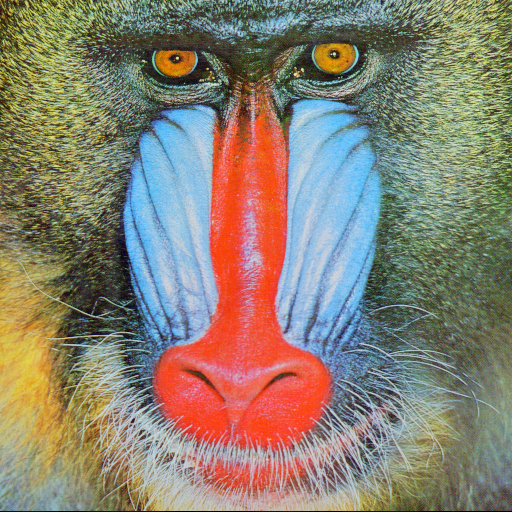


JPEG Quantization:


compression ratio: 0.0318903923034668 (31:1), nnz ratio = 0.020193735758463543

Tiled DCT Hard Thresholding:


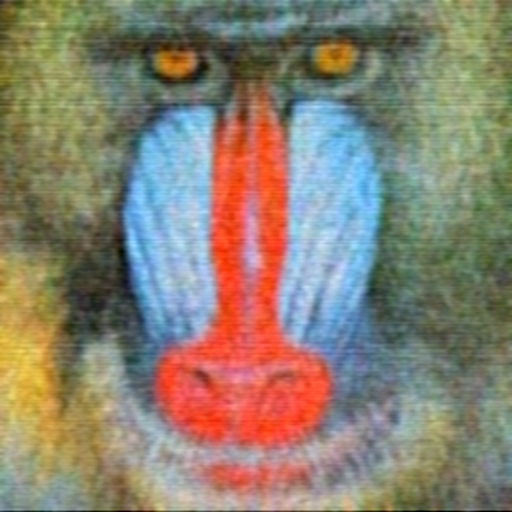

compression ratio: 0.010290145874023438 (97:1), nnz ratio = 0.00316619873046875


In [5]:
img = testimage("mandrill")
println("Original Image");
display(img)

# standard JPEG (1992)
println("\nJPEG Quantization:");
compImg, bits, nnzC, nnzO, _, _ = jpegQuantCompress(img, [8 8 8])
display(compImg)
cr = bits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)

# hard thresholding of entire image DCT
println("\nTiled DCT Hard Thresholding:");
compImg, bits, nnzC, nnzO, _, _ = jpegThreshCompress(img, [0.0055 0.002 0.002], 512)
display(compImg)
cr = bits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)

# JPEG2000 Compression With Discrete Wavelet Transform

In [6]:
function countRLEBits(imgArray, subbandQuantization, numSubbandLevels)
    bits = 0
    if imgArray[1, 1] != 0
        bits += 8
    end
    # calculate optimal tile size
    nnz = count(i->(i!=0), imgArray);
    optNonzeroPerTile = 4
    tileSize = 2^(ceil(Int32, log2(sqrt(optNonzeroPerTile*length(imgArray)/nnz))))
    for i=1:numSubbandLevels
        # store the max value seen in the subband to reduce the required number 
        # of bits required for storing nonzero values
        # maximum max value is 256*length(imgArray)
        # this happens if the entire energy of the image is compacted into
        # a single pixel in the DWT domain
        bits += ceil(log2(256*length(imgArray)/subbandQuantization[i]))
        wlo = 2^(i-1)+1
        whi = 2^i
        lhMax = maximum(view(imgArray, 1:wlo-1, wlo:whi))
        hlMax = maximum(view(imgArray, wlo:whi, 1:wlo-1))
        hhMax = maximum(view(imgArray, wlo:whi, wlo:whi))
        max = ceil(maximum([lhMax, hlMax, hhMax, subbandQuantization[i]]))
        dataBits = ceil(log2(max/subbandQuantization[i]))
        if wlo - 1 > tileSize
            runBits = ceil(log2(tileSize*tileSize))
            bitsPerNonZero = runBits + dataBits
            numTiles = div(wlo-1, tileSize)
            for subband = 1:3
                if subband == 1
                    xOffset = 1
                    yOffset = wlo
                elseif subband == 2
                    xOffset = wlo
                    yOffset = wlo
                else
                    xOffset = wlo
                    yOffset = 1
                end
                finalZero = false
                for i = 1:numTiles
                    for j = 1:numTiles
                        for iTile = 0:tileSize-1
                            for jTile = 0:tileSize-1
                                x = (i-1)*tileSize + iTile + xOffset
                                y = (j-1)*tileSize + jTile + yOffset
                                finalZero = true
                                if imgArray[x, y] != 0
                                    finalZero = false
                                    bits += bitsPerNonZero
                                end
                            end
                        end
                        if finalZero
                            # don't need bits for data because decoder can sum previous RLE lengths
                            # in this tile with this last piece of data and determine that the final
                            # value was zero
                            bits += runBits
                        end
                    end
                end
            end
        else
            runBits = ceil(log2((wlo-1)*(wlo-1)))
            bitsPerNonZero = runBits + dataBits
            finalZero = false
            for i = 1:whi
                for j = 1:whi
                    if i < wlo && j < wlo
                        # only count bits for current subband
                        continue
                    end
                    finalZero = true
                    if imgArray[i, j] != 0
                        finalZero = false
                        bits += bitsPerNonZero
                    end
                end
            end
            if finalZero
                bits += runBits
            end
        end
    end
    return bits
end

function makeWaveletQuantTable(numSubbands, maxQuant, subbandReductionRatio)
    quantTable = ones(3, numSubbands).*maxQuant
    for i=1:numSubbands-1
        quantTable[:,numSubbands-i] = quantTable[:,numSubbands-i+1]./subbandReductionRatio
    end
    quantTable = ceil.(quantTable)
    quantTable[quantTable .< 1] .= 1;
    return quantTable
end

function waveletThresholdCompress(rgbImg, compRatio)
    wt = wavelet(WT.cdf97, WT.Lifting)
    YpCbCr = RGB2YpCbCr(rgbImg)
    dwtHOrig = zeros(3)
    dwtHThresh = zeros(3)
    nnzOrig = 0
    nnzThresh = 0
    bits = 0
    for c = 1:3
        channel = YpCbCr[:,:,c]
        dwt!(channel, wt)
        dwtHOrig[c] = entropy(log2, channel)
        nnzOrig += count(i->(i!=0), channel)
        threshold2D!(channel, compRatio[c])
        dwtHThresh[c] = entropy(log2, channel)
        nnzThresh += count(i->(i!=0), channel)
        # zigzag traverse subbands of wavelet tree to do run length encoding
        # for each subband, just traverse 2D array normally (row-major/col-major order)
        # get number of subband levels (e.g. 9 for 512x512 image)
        numSubbandLevels = maxtransformlevels(channel)
        bits += countRLEBits(channel, ones(numSubbandLevels), numSubbandLevels)
        idwt!(channel, wt)
        YpCbCr[:,:,c] = channel
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, bits, nnzThresh, nnzOrig, dwtHThresh, dwtHOrig
end

function waveletQuantizedCompress(rgbImg, qualityFactor)
    wt = wavelet(WT.cdf97, WT.Lifting)
    nSubbands = maxtransformlevels(rgbImg)
    S = zeros(3);
    for c = 1:3
        if (qualityFactor[c] < 50)
            S[c] = 5000/qualityFactor[c]
        else
            S[c] = 200 - 2*qualityFactor[c]
        end
    end
    mQ, mQIdx = findmax(qualityFactor);
    initialQuant = floor.((S.*30 .+ 50)./100)
    qualityReductionRatio = mQ^(1/nSubbands);
    quantTable = makeWaveletQuantTable(nSubbands, initialQuant, qualityReductionRatio)
    YpCbCr = RGB2YpCbCr(rgbImg)
    dwtHOrig = zeros(3)
    dwtHQuant = zeros(3)
    nnzOrig = 0
    nnzQuant = 0
    bits = 0
    for c = 1:3
        channel = YpCbCr[:,:,c]
        dwt!(channel, wt)
        dwtHOrig[c] = entropy(log2, channel)
        nnzOrig += count(i->(i!=0), channel)
        # create wavelet transform quantization table
        # Do subband scalar quantization (https://www2.seas.gwu.edu/~ayoussef/papers/FingerPrintWSQ-chapter.pdf)
        # get number of subband levels (e.g. 9 for 512x512 image)
        numSubbandLevels = maxtransformlevels(channel)
        # do strong quantization of highest subband levels
        # don't quantize DC subband
        for i=1:numSubbandLevels
            wlo = 2^(i-1)+1
            whi = 2^i
            subband = view(channel, wlo:whi, 1:whi)
            channel[wlo:whi, 1:whi] = sign.(subband) .* quantTable[c, i] .* floor.(abs.(subband) ./ quantTable[c, i]);
            subband = view(channel, 1:wlo-1, wlo:whi)
            channel[1:wlo-1, wlo:whi] = sign.(subband) .* quantTable[c, i] .* floor.(abs.(subband) ./ quantTable[c, i]);
        end
        dwtHQuant[c] = entropy(log2, channel)
        nnzQuant += count(i->(i!=0), channel)
        bits += countRLEBits(channel, quantTable, numSubbandLevels)
        idwt!(channel, wt)
        YpCbCr[:,:,c] = channel
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, bits, nnzQuant, nnzOrig, dwtHQuant, dwtHOrig
end

waveletQuantizedCompress (generic function with 1 method)

Original Image

Wavelet Thresholding with Tiled RLE


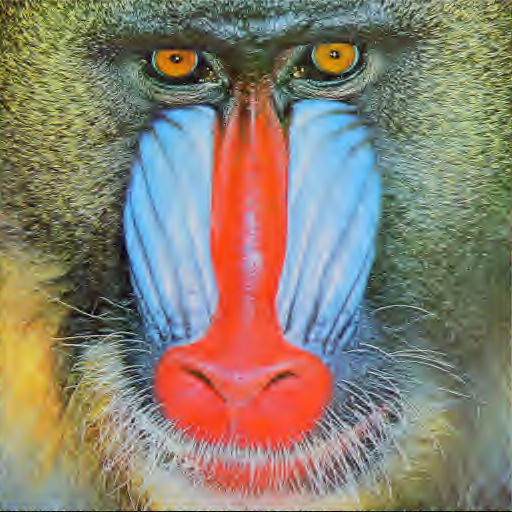

compression ratio: 0.06368303298950195 (16:1), nnz ratio = 0.030000050862630207
Original DWT entropy (YCbCr) = [0.29402052750108965, 0.015052235721656482, 0.018023202391280965]
Compressed DWT entropy (YCbCr) = [0.1774539767904531, 0.015052235721656482, 0.018023202391280965]

Wavelet Quantization with tiled RLE


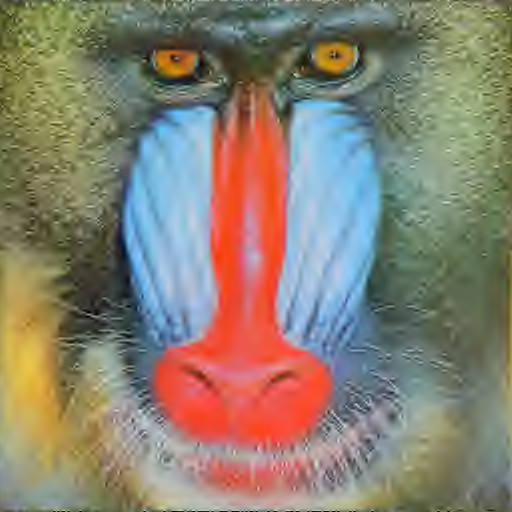

compression ratio: 0.010594526926676432 (94:1), nnz ratio = 0.005808512369791667
Original DWT entropy (YCbCr) = [0.29402052750108965, 0.015052235721656482, 0.018023202391280965]
Compressed DWT entropy (YCbCr) = [0.06712123080850109, 0.01201740912681206, 0.01616229521426679]


In [7]:
img = testimage("mandrill")
println("Original Image");

# wavelet threshold compression with tiled RLE
println("\nWavelet Thresholding with Tiled RLE")
compImg, bits, nnzC, nnzO, dwtHComp, dwtHOrig = waveletThresholdCompress(img, [0.05 0.02 0.02])
display(compImg)
cr = bits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)
println("Original DWT entropy (YCbCr) = ", dwtHOrig)
println("Compressed DWT entropy (YCbCr) = ", dwtHComp)

# wavelet quantization with tiled RLE
println("\nWavelet Quantization with tiled RLE")
compImg, bits, nnzC, nnzO, dwtHComp, dwtHOrig = waveletQuantizedCompress(img, [10.8 9 9])
display(compImg)
cr = bits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)
println("Original DWT entropy (YCbCr) = ", dwtHOrig)
println("Compressed DWT entropy (YCbCr) = ", dwtHComp)

# SVD-based Quantization/Thresholding
Approach:
Compute DWT to get a transform of image, then compute SVD of transform to determine relevant components of image.
Then truncate transform to "relevant" portions with SVD.
Finally, do an inverse DWT to reconstruct the image from the truncated transform.
This actually is no different from performing an SVD of the original image (since the DWT is a linear transformation, so it preserves singular values).

In [8]:
function svdThreshCompress(rgbImg, rankCompressionRatio, thresholdRatio)
    wt = wavelet(WT.cdf97, WT.Lifting)
    YpCbCr = RGB2YpCbCr(rgbImg)
    svdBits = 0
    rleBits = 0
    nnzComp = 0
    nnzOrig = 0
    dwtHOrig = zeros(3)
    dwtHComp = zeros(3)
    for c = 1:3
        dwtImg = dwt(YpCbCr[:,:,c], wt)
        nnzOrig += count(i->(i!=0), dwtImg)
        dwtHOrig[c] = entropy(log2, dwtImg)
        F = svd(dwtImg, full=true)
        numSingular = floor(Int, length(F.S)*rankCompressionRatio[c])
        svdBits += numSingular*(sum(size(rgbImg)) + 1) * 8
        Snew = zeros(length(F.S))
        for i = 1:numSingular
            Snew[i] = F.S[i]
        end
        dwtImg = F.U*Diagonal(Snew)*F.Vt
        threshold2D!(dwtImg, thresholdRatio[c])
        numSubbandLevels = maxtransformlevels(dwtImg)
        rleBits += countRLEBits(dwtImg, ones(numSubbandLevels), numSubbandLevels)
        nnzComp += count(i->(i!=0), dwtImg)
        dwtHComp[c] = entropy(log2, dwtImg)
        compImg = idwt(dwtImg, wt)
        YpCbCr[:,:,c] = compImg
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, svdBits, rleBits, nnzComp, nnzOrig, dwtHComp, dwtHOrig
end

function spatialSVDCompress(rgbImg, rankCompressionRatio, thresholdRatio)
    YpCbCr = RGB2YpCbCr(rgbImg)
    svdBits = 0
    for c = 1:3
        F = svd(YpCbCr[:,:,c], full=true)
        numSingular = floor(Int, length(F.S)*rankCompressionRatio[c])
        svdBits += numSingular*(sum(size(rgbImg)) + 1) * 8
        Snew = zeros(length(F.S))
        for i = 1:numSingular
            Snew[i] = F.S[i]
        end
        compImg = F.U*Diagonal(Snew)*F.Vt
        YpCbCr[:,:,c] = compImg
    end
    RGB = YpCbCr2RGB(YpCbCr)
    return RGB, svdBits, 0, 0, 0, 0, 0
end

spatialSVDCompress (generic function with 1 method)

Original Image


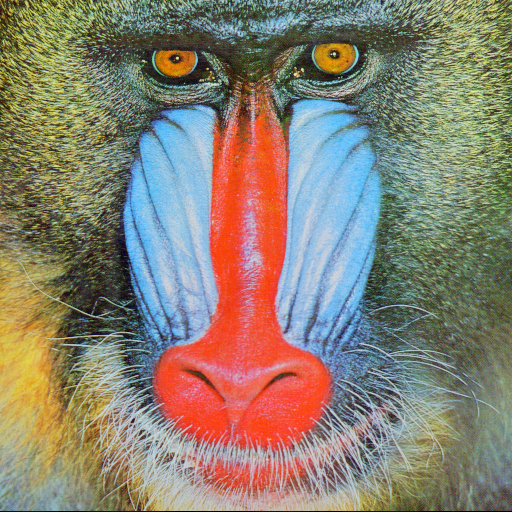


DWT-SVD Compression


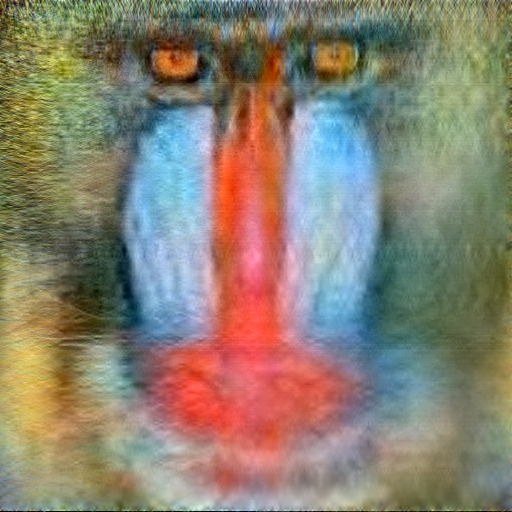

compression ratio: 0.031280517578125 (32:1), nnz ratio = 1.0
Original DWT entropy (YCbCr) = [0.29402052750108965, 0.015052235721656482, 0.018023202391280965]
Compressed DWT entropy (YCbCr) = [0.04182579366484219, 0.009993068002524131, 0.009100919043464148]
RGB-MSE: 0.014488235377431963
Y-MSE: 0.007036655669608205
dE2000: 0.003245299851227186
RGB-PSNR: 18.38984507041769
Y-PSNR: 21.52633700137568
dE2000-PSNR: 24.887451701372246

SVD-Only Compression


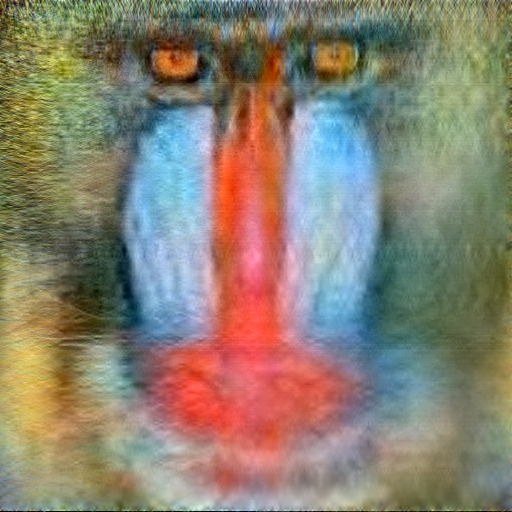

compression ratio: 0.031280517578125 (32:1), nnz ratio = 1.0
RGB-MSE: 0.014488235377431963
Y-MSE: 0.007036655669608205
dE2000: 0.003245299851227186
RGB-PSNR: 18.38984507041769
Y-PSNR: 21.52633700137568
dE2000-PSNR: 24.887451701372246

SVD+Thresholding Compression


compression ratio: 0.18394692738850912 (5:1), nnz ratio = 0.09999974568684895
Original DWT entropy (YCbCr) = [0.29402052750108965, 0.015052235721656482, 0.018023202391280965]
Compressed DWT entropy (YCbCr) = [0.2788482775702681, 0.014240460383951908, 0.016737275527347523]
RGB-MSE: 0.0031114156660140752
Y-MSE: 0.001000200530585698
dE2000: 0.0011165016390810192
RGB-PSNR: 25.070419659413087
Y-PSNR: 29.99912919404048
dE2000-PSNR: 29.521406350257546


(0.0031114156660140752, 0.001000200530585698, 0.0011165016390810192)

In [9]:
img = testimage("mandrill")
println("Original Image");
display(img)

println("\nDWT-SVD Compression");
compImg, svdBits, rleBits, nnzC, nnzO, dwtHComp, dwtHOrig = svdThreshCompress(img, [0.25 0.05 0.05], [1 1 1])
save("writeup/images/mandrill_SVD_4x_PSNR_29.png", compImg)
compImg, svdBits, rleBits, nnzC, nnzO, dwtHComp, dwtHOrig = svdThreshCompress(img, [0.0065 0.0055 0.0055], [1 1 1])
save("writeup/images/mandrill_SVD_110x_PSNR_23.png", compImg)
compImg, svdBits, rleBits, nnzC, nnzO, dwtHComp, dwtHOrig = svdThreshCompress(img, [0.032 0.009 0.009], [1 1 1])
save("writeup/images/mandrill_SVD_32x_PSNR_25.png", compImg)
compImg, svdBits, rleBits, nnzC, nnzO, dwtHComp, dwtHOrig = svdThreshCompress(img, [0.032 0.009 0.009], [1 1 1])
display(compImg)
cr = svdBits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)
println("Original DWT entropy (YCbCr) = ", dwtHOrig)
println("Compressed DWT entropy (YCbCr) = ", dwtHComp)
rgbMSE, yMSE, cdiffMSE = evaluateMSE(img, compImg)


println("\nSVD-Only Compression");
compImg, svdBits, rleBits, nnzC, nnzO, dwtHComp, dwtHOrig = svdThreshCompress(img, [0.032 0.009 0.009], [1 1 1])
display(compImg)
cr = svdBits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)
rgbMSE, yMSE, cdiffMSE = evaluateMSE(img, compImg)

# next try hybrid method: moderate compression with SVD, then hard thresholding?
# perhaps an improvement, hard to tell
# with fine tuning of SVD compression, can achieve improvement in PSNR
# only very minimal improvement (~mdB) in PSNR --- no perceived impact
# however, most of the time, this underperforms just normal thresholding
# similar to: https://www.sciencedirect.com/science/article/pii/S1051200413001929
println("\nSVD+Thresholding Compression");
rankRatio = [0.4 0.05 0.05]
threshRatio = [0.2 0.05 0.05]
compImg, svdBits, rleBits, nnzC, nnzO, dwtHComp, dwtHOrig = svdThreshCompress(img, rankRatio, threshRatio)
display(compImg)
cr = rleBits / (24*length(compImg))
println("compression ratio: ", cr, " (", round(Int,1/cr), ":1), nnz ratio = ", nnzC/nnzO)
println("Original DWT entropy (YCbCr) = ", dwtHOrig)
println("Compressed DWT entropy (YCbCr) = ", dwtHComp)
rgbMSE, yMSE, cdiffMSE = evaluateMSE(img, compImg)

# Evaluation of PSNR vs. Compression Ratio for Various Methods
- DCT-quant
- DCT-thresh
- DWT-quant
- DWT-thresh
- DWT-SVD
- DWT-SVD-thresh

In [10]:
function evaluateNonSVDThresh(compressionMethod, img)
    cr = zeros(20)
    nnz = zeros(20)
    rgbPsnr = zeros(20)
    yPsnr = zeros(20)
    dE2000Psnr = zeros(20)
    for c = 1:20
        reqCr = 2/((2*c)^1.5+1)
        compImg, bits, nnzC, nnzO, dwtHC, dwtHO = compressionMethod(img, [reqCr reqCr/4 reqCr/4])
        cr[c] = bits / (24*length(compImg))
        nnz[c] = nnzC / nnzO
        rgbMSE, yMSE, dE2000MSE = evaluateMSE(img, compImg, false)
        rgbPsnr[c] = -10*log10(rgbMSE)
        yPsnr[c] = -10*log10(yMSE)
        dE2000Psnr[c] = -10*log10(dE2000MSE)
    end
    return cr, nnz, rgbPsnr, dE2000Psnr, yPsnr
end

function evaluateNonSVDQuant(compressionMethod, img)
    cr = zeros(20)
    nnz = zeros(20)
    rgbPsnr = zeros(20)
    yPsnr = zeros(20)
    dE2000Psnr = zeros(20)
    for q = 1:20
        reqQ = 5*(q-1)+1;
        compImg, bits, nnzC, nnzO, dwtHC, dwtHO = compressionMethod(img, [reqQ reqQ*0.8 reqQ*0.8])
        cr[q] = bits / (24*length(compImg))
        nnz[q] = nnzC / nnzO
        rgbMSE, yMSE, dE2000MSE = evaluateMSE(img, compImg, false)
        rgbPsnr[q] = -10*log10(rgbMSE)
        yPsnr[q] = -10*log10(yMSE)
        dE2000Psnr[q] = -10*log10(dE2000MSE)
    end
    return cr, nnz, rgbPsnr, dE2000Psnr, yPsnr
end

evaluateNonSVDQuant (generic function with 1 method)

In [11]:
# Actually evaluate methods (these are split up since they take a long time to run)
# _m = testimage("mandrill")
# _p = testimage("peppers")
# _l = testimage("lighthouse")[:,128:639]
# _b = testimage("monarch_color")[:,155:666]
# _a = testimage("airplaneF16")

# DCT Quant
dctQuant(img, qualityFactor) = jpegQuantCompress(img, qualityFactor)
cr_cq_m, nnz_cq_m, rgbPsnr_cq_m, dE2000Psnr_cq_m, yPsnr_cq_m = evaluateNonSVDQuant(dctQuant, testimage("mandrill"));
cr_cq_p, nnz_cq_p, rgbPsnr_cq_p, dE2000Psnr_cq_p, yPsnr_cq_p = evaluateNonSVDQuant(dctQuant, testimage("peppers"));
cr_cq_l, nnz_cq_l, rgbPsnr_cq_l, dE2000Psnr_cq_l, yPsnr_cq_l = evaluateNonSVDQuant(dctQuant, testimage("lighthouse")[:,128:639]);
cr_cq_b, nnz_cq_b, rgbPsnr_cq_b, dE2000Psnr_cq_b, yPsnr_cq_b = evaluateNonSVDQuant(dctQuant, testimage("monarch_color")[:,155:666]);
cr_cq_a, nnz_cq_a, rgbPsnr_cq_a, dE2000Psnr_cq_a, yPsnr_cq_a = evaluateNonSVDQuant(dctQuant, testimage("airplaneF16"));

In [12]:
# DCT Thresh
dctThresh(img, compRatio) = jpegThreshCompress(img, compRatio, 8)
cr_ct_m, nnz_ct_m, rgbPsnr_ct_m, dE2000Psnr_ct_m, yPsnr_ct_m = evaluateNonSVDThresh(dctThresh, testimage("mandrill"));
cr_ct_p, nnz_ct_p, rgbPsnr_ct_p, dE2000Psnr_ct_p, yPsnr_ct_p = evaluateNonSVDThresh(dctThresh, testimage("peppers"));
cr_ct_l, nnz_ct_l, rgbPsnr_ct_l, dE2000Psnr_ct_l, yPsnr_ct_l = evaluateNonSVDThresh(dctThresh, testimage("lighthouse")[:,128:639]);
cr_ct_b, nnz_ct_b, rgbPsnr_ct_b, dE2000Psnr_ct_b, yPsnr_ct_b = evaluateNonSVDThresh(dctThresh, testimage("monarch_color")[:,155:666]);
cr_ct_a, nnz_ct_a, rgbPsnr_ct_a, dE2000Psnr_ct_a, yPsnr_ct_a = evaluateNonSVDThresh(dctThresh, testimage("airplaneF16"));

In [13]:
# DWT Quant
dwtQuant(img, qualityFactor) = waveletQuantizedCompress(img, qualityFactor)
cr_wq_m, nnz_wq_m, rgbPsnr_wq_m, dE2000Psnr_wq_m, yPsnr_wq_m = evaluateNonSVDQuant(dwtQuant, testimage("mandrill"));
cr_wq_p, nnz_wq_p, rgbPsnr_wq_p, dE2000Psnr_wq_p, yPsnr_wq_p = evaluateNonSVDQuant(dwtQuant, testimage("peppers"));
cr_wq_l, nnz_wq_l, rgbPsnr_wq_l, dE2000Psnr_wq_l, yPsnr_wq_l = evaluateNonSVDQuant(dwtQuant, testimage("lighthouse")[:,128:639]);
cr_wq_b, nnz_wq_b, rgbPsnr_wq_b, dE2000Psnr_wq_b, yPsnr_wq_b = evaluateNonSVDQuant(dwtQuant, testimage("monarch_color")[:,155:666]);
cr_wq_a, nnz_wq_a, rgbPsnr_wq_a, dE2000Psnr_wq_a, yPsnr_wq_a = evaluateNonSVDQuant(dwtQuant, testimage("airplaneF16"));

In [14]:
# DWT Thresh
dwtThresh(img, compRatio) = waveletThresholdCompress(img, compRatio)
cr_wt_m, nnz_wt_m, rgbPsnr_wt_m, dE2000Psnr_wt_m, yPsnr_wt_m = evaluateNonSVDThresh(dwtThresh, testimage("mandrill"));
cr_wt_p, nnz_wt_p, rgbPsnr_wt_p, dE2000Psnr_wt_p, yPsnr_wt_p = evaluateNonSVDThresh(dwtThresh, testimage("peppers"));
cr_wt_l, nnz_wt_l, rgbPsnr_wt_l, dE2000Psnr_wt_l, yPsnr_wt_l = evaluateNonSVDThresh(dwtThresh, testimage("lighthouse")[:,128:639]);
cr_wt_b, nnz_wt_b, rgbPsnr_wt_b, dE2000Psnr_wt_b, yPsnr_wt_b = evaluateNonSVDThresh(dwtThresh, testimage("monarch_color")[:,155:666]);
cr_wt_a, nnz_wt_a, rgbPsnr_wt_a, dE2000Psnr_wt_a, yPsnr_wt_a = evaluateNonSVDThresh(dwtThresh, testimage("airplaneF16"));

In [15]:
# DWT SVD
dwtSVD(img, compRatio) = svdThreshCompress(img, compRatio, [1 1 1])
cr_sv_m, nnz_sv_m, rgbPsnr_sv_m, dE2000Psnr_sv_m, yPsnr_sv_m = evaluateNonSVDThresh(dwtSVD, testimage("mandrill"));
cr_sv_p, nnz_sv_p, rgbPsnr_sv_p, dE2000Psnr_sv_p, yPsnr_sv_p = evaluateNonSVDThresh(dwtSVD, testimage("peppers"));
cr_sv_l, nnz_sv_l, rgbPsnr_sv_l, dE2000Psnr_sv_l, yPsnr_sv_l = evaluateNonSVDThresh(dwtSVD, testimage("lighthouse")[:,128:639]);
cr_sv_b, nnz_sv_b, rgbPsnr_sv_b, dE2000Psnr_sv_b, yPsnr_sv_b = evaluateNonSVDThresh(dwtSVD, testimage("monarch_color")[:,155:666]);
cr_sv_a, nnz_sv_a, rgbPsnr_sv_a, dE2000Psnr_sv_a, yPsnr_sv_a = evaluateNonSVDThresh(dwtSVD, testimage("airplaneF16"));

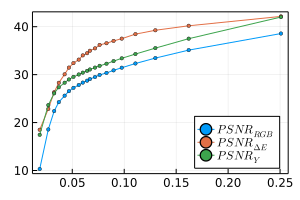

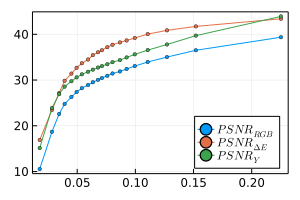

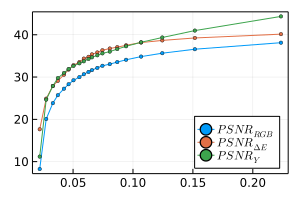

In [16]:
# results of DCT Quant
p = plot(cr_cq_m, [rgbPsnr_cq_m dE2000Psnr_cq_m yPsnr_cq_m], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/mandrill/dct_quant.png")
p = plot(cr_cq_p, [rgbPsnr_cq_p dE2000Psnr_cq_p yPsnr_cq_p], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/peppers/dct_quant.png")
p = plot(cr_cq_l, [rgbPsnr_cq_l dE2000Psnr_cq_l yPsnr_cq_l], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/lighthouse/dct_quant.png")
p = plot(cr_cq_b, [rgbPsnr_cq_b dE2000Psnr_cq_b yPsnr_cq_b], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/monarch_color/dct_quant.png")
p = plot(cr_cq_a, [rgbPsnr_cq_a dE2000Psnr_cq_a yPsnr_cq_a], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/airplaneF16/dct_quant.png")

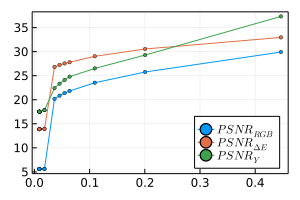

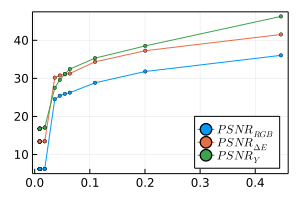

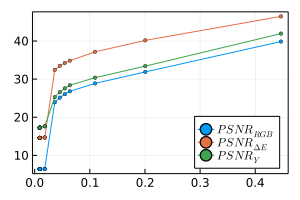

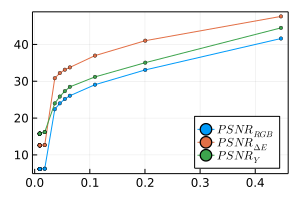

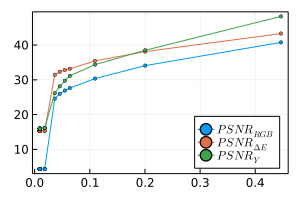

In [17]:
# results of DCT Thresh
p = plot(cr_ct_m, [rgbPsnr_ct_m dE2000Psnr_ct_m yPsnr_ct_m], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/mandrill/dct_thresh.png")
p = plot(cr_ct_p, [rgbPsnr_ct_p dE2000Psnr_ct_p yPsnr_ct_p], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/peppers/dct_thresh.png")
p = plot(cr_ct_l, [rgbPsnr_ct_l dE2000Psnr_ct_l yPsnr_ct_l], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/lighthouse/dct_thresh.png")
p = plot(cr_ct_b, [rgbPsnr_ct_b dE2000Psnr_ct_b yPsnr_ct_b], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/monarch_color/dct_thresh.png")
p = plot(cr_ct_a, [rgbPsnr_ct_a dE2000Psnr_ct_a yPsnr_ct_a], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/airplaneF16/dct_thresh.png")

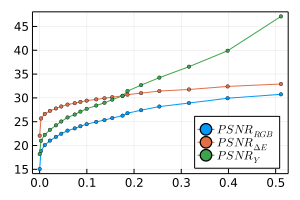

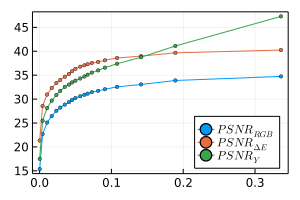

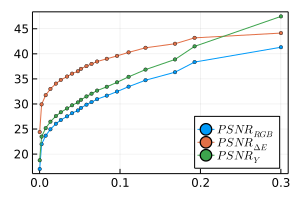

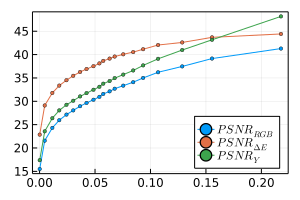

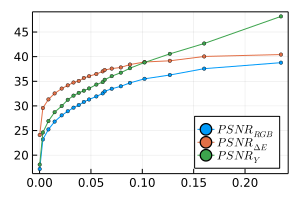

In [18]:
# results of DWT Quant
p = plot(cr_wq_m, [rgbPsnr_wq_m dE2000Psnr_wq_m yPsnr_wq_m], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/mandrill/dwt_quant.png")
p = plot(cr_wq_p, [rgbPsnr_wq_p dE2000Psnr_wq_p yPsnr_wq_p], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/peppers/dwt_quant.png")
p = plot(cr_wq_l, [rgbPsnr_wq_l dE2000Psnr_wq_l yPsnr_wq_l], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/lighthouse/dwt_quant.png")
p = plot(cr_wq_b, [rgbPsnr_wq_b dE2000Psnr_wq_b yPsnr_wq_b], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/monarch_color/dwt_quant.png")
p = plot(cr_wq_a, [rgbPsnr_wq_a dE2000Psnr_wq_a yPsnr_wq_a], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/airplaneF16/dwt_quant.png")

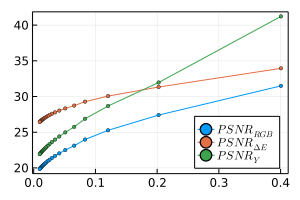

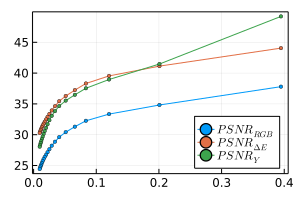

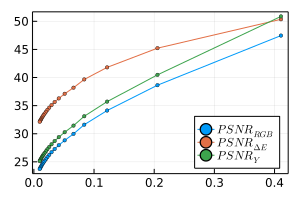

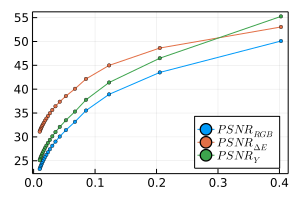

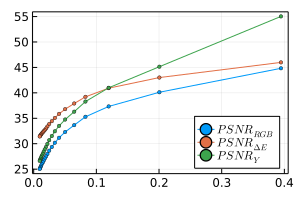

In [19]:
# results of DWT Thresh
p = plot(cr_wt_m, [rgbPsnr_wt_m dE2000Psnr_wt_m yPsnr_wt_m], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/mandrill/dwt_thresh.png")
p = plot(cr_wt_p, [rgbPsnr_wt_p dE2000Psnr_wt_p yPsnr_wt_p], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/peppers/dwt_thresh.png")
p = plot(cr_wt_l, [rgbPsnr_wt_l dE2000Psnr_wt_l yPsnr_wt_l], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/lighthouse/dwt_thresh.png")
p = plot(cr_wt_b, [rgbPsnr_wt_b dE2000Psnr_wt_b yPsnr_wt_b], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/monarch_color/dwt_thresh.png")
p = plot(cr_wt_a, [rgbPsnr_wt_a dE2000Psnr_wt_a yPsnr_wt_a], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/airplaneF16/dwt_thresh.png")

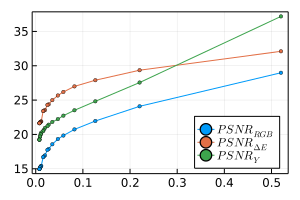

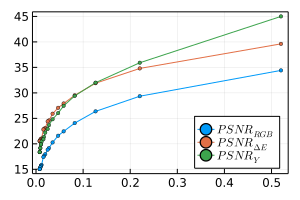

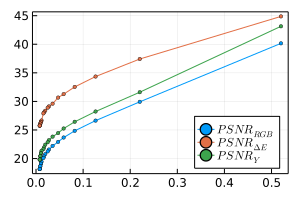

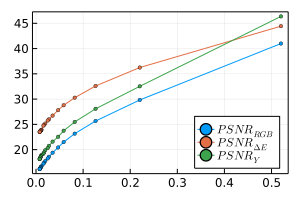

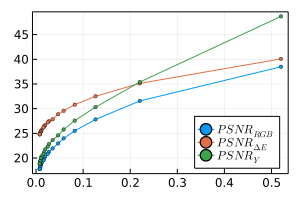

In [20]:
# results of SVD
p = plot(cr_sv_m, [rgbPsnr_sv_m dE2000Psnr_sv_m yPsnr_sv_m], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/mandrill/svd.png")
p = plot(cr_sv_p, [rgbPsnr_sv_p dE2000Psnr_sv_p yPsnr_sv_p], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/peppers/svd.png")
p = plot(cr_sv_l, [rgbPsnr_sv_l dE2000Psnr_sv_l yPsnr_sv_l], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/lighthouse/svd.png")
p = plot(cr_sv_b, [rgbPsnr_sv_b dE2000Psnr_sv_b yPsnr_sv_b], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/monarch_color/svd.png")
p = plot(cr_sv_a, [rgbPsnr_sv_a dE2000Psnr_sv_a yPsnr_sv_a], m=2, labels = [L"PSNR_{RGB}" L"PSNR_{\Delta E}" L"PSNR_Y"])
display(plot(p, size = (300, 200), widen=true, framestyle=:box, legend=:bottomright))
savefig("writeup/images/cr_psnr_plots/airplaneF16/svd.png")

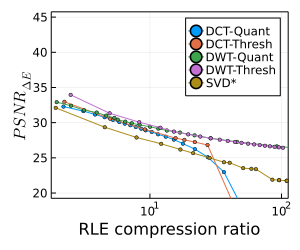

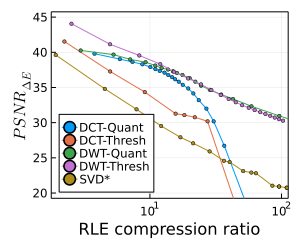

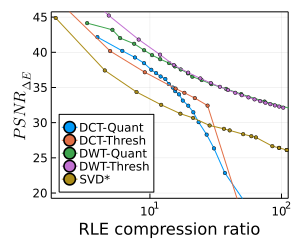

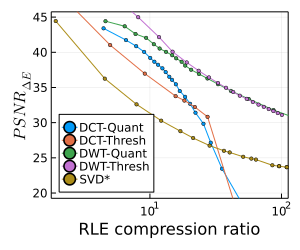

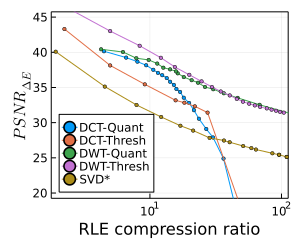

In [21]:
# compare DCT Quant, DCT Thresh, DWT Quant, DWT Thresh, SVD
p = plot(1 ./[cr_cq_m cr_ct_m cr_wq_m cr_wt_m cr_sv_m], [dE2000Psnr_cq_m dE2000Psnr_ct_m dE2000Psnr_wq_m dE2000Psnr_wt_m dE2000Psnr_sv_m], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh" "SVD*"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:topright, dpi=300, xlims=(2, 100), ylims=(20, 45), xaxis=:log, ylabel=L"PSNR_{\Delta E}", xlabel="RLE compression ratio"))
savefig("writeup/images/cr_psnr_plots/mandrill/comparison.png")
p = plot(1 ./[cr_cq_p cr_ct_p cr_wq_p cr_wt_p cr_sv_p], [dE2000Psnr_cq_p dE2000Psnr_ct_p dE2000Psnr_wq_p dE2000Psnr_wt_p dE2000Psnr_sv_p], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh" "SVD*"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, dpi=300, xlims=(2, 100), ylims=(20, 45), xaxis=:log, ylabel=L"PSNR_{\Delta E}", xlabel="RLE compression ratio"))
savefig("writeup/images/cr_psnr_plots/peppers/comparison.png")
p = plot(1 ./[cr_cq_l cr_ct_l cr_wq_l cr_wt_l cr_sv_l], [dE2000Psnr_cq_l dE2000Psnr_ct_l dE2000Psnr_wq_l dE2000Psnr_wt_l dE2000Psnr_sv_l], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh" "SVD*"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, dpi=300, xlims=(2, 100), ylims=(20, 45), xaxis=:log, ylabel=L"PSNR_{\Delta E}", xlabel="RLE compression ratio"))
savefig("writeup/images/cr_psnr_plots/lighthouse/comparison.png")
p = plot(1 ./[cr_cq_b cr_ct_b cr_wq_b cr_wt_b cr_sv_b], [dE2000Psnr_cq_b dE2000Psnr_ct_b dE2000Psnr_wq_b dE2000Psnr_wt_b dE2000Psnr_sv_b], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh" "SVD*"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, dpi=300, xlims=(2, 100), ylims=(20, 45), xaxis=:log, ylabel=L"PSNR_{\Delta E}", xlabel="RLE compression ratio"))
savefig("writeup/images/cr_psnr_plots/monarch_color/comparison.png")
p = plot(1 ./[cr_cq_a cr_ct_a cr_wq_a cr_wt_a cr_sv_a], [dE2000Psnr_cq_a dE2000Psnr_ct_a dE2000Psnr_wq_a dE2000Psnr_wt_a dE2000Psnr_sv_a], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh" "SVD*"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, dpi=300, xlims=(2, 100), ylims=(20, 45), xaxis=:log, ylabel=L"PSNR_{\Delta E}", xlabel="RLE compression ratio"))
savefig("writeup/images/cr_psnr_plots/airplaneF16/comparison.png")

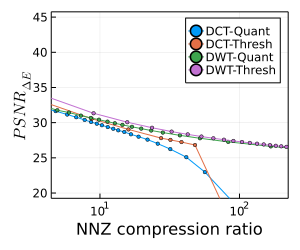

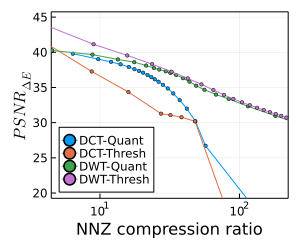

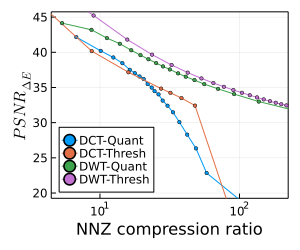

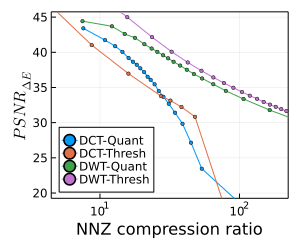

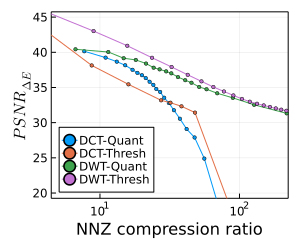

In [22]:
# compare using nnz as proxy for compression ratio
p = plot(1 ./[nnz_cq_m nnz_ct_m nnz_wq_m nnz_wt_m], [dE2000Psnr_cq_m dE2000Psnr_ct_m dE2000Psnr_wq_m dE2000Psnr_wt_m], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:topright, xlims=(5, 200), ylims=(20, 45), xaxis=:log, dpi=300, ylabel=L"PSNR_{\Delta E}", xlabel="NNZ compression ratio"))
savefig("writeup/images/cr_psnr_plots/mandrill/nnz_comparison.png")
p = plot(1 ./[nnz_cq_p nnz_ct_p nnz_wq_p nnz_wt_p], [dE2000Psnr_cq_p dE2000Psnr_ct_p dE2000Psnr_wq_p dE2000Psnr_wt_p], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, xlims=(5, 200), ylims=(20, 45), xaxis=:log, dpi=300, ylabel=L"PSNR_{\Delta E}", xlabel="NNZ compression ratio"))
savefig("writeup/images/cr_psnr_plots/peppers/nnz_comparison.png")
p = plot(1 ./[nnz_cq_l nnz_ct_l nnz_wq_l nnz_wt_l], [dE2000Psnr_cq_l dE2000Psnr_ct_l dE2000Psnr_wq_l dE2000Psnr_wt_l], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, xlims=(5, 200), ylims=(20, 45), xaxis=:log, dpi=300, ylabel=L"PSNR_{\Delta E}", xlabel="NNZ compression ratio"))
savefig("writeup/images/cr_psnr_plots/lighthouse/nnz_comparison.png")
p = plot(1 ./[nnz_cq_b nnz_ct_b nnz_wq_b nnz_wt_b], [dE2000Psnr_cq_b dE2000Psnr_ct_b dE2000Psnr_wq_b dE2000Psnr_wt_b], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, xlims=(5, 200), ylims=(20, 45), xaxis=:log, dpi=300, ylabel=L"PSNR_{\Delta E}", xlabel="NNZ compression ratio"))
savefig("writeup/images/cr_psnr_plots/monarch_color/nnz_comparison.png")
p = plot(1 ./[nnz_cq_a nnz_ct_a nnz_wq_a nnz_wt_a], [dE2000Psnr_cq_a dE2000Psnr_ct_a dE2000Psnr_wq_a dE2000Psnr_wt_a], m=2, labels = ["DCT-Quant" "DCT-Thresh" "DWT-Quant" "DWT-Thresh"])
display(plot(p, size = (300, 250), widen=true, framestyle=:box, legend=:bottomleft, xlims=(5, 200), ylims=(20, 45), xaxis=:log, dpi=300, ylabel=L"PSNR_{\Delta E}", xlabel="NNZ compression ratio"))
savefig("writeup/images/cr_psnr_plots/airplaneF16/nnz_comparison.png")

# Discrete Wavelet Transform Visualization

Original Image


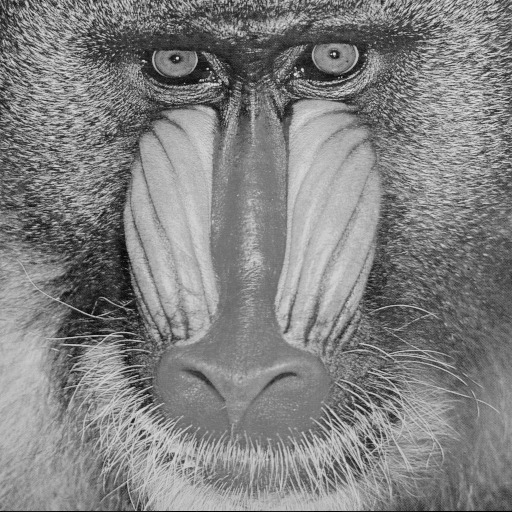

Wavelet Transform


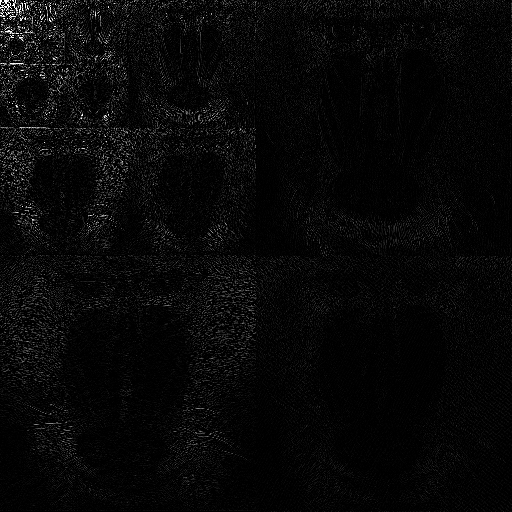

Log-amplitude Wavelet Transform


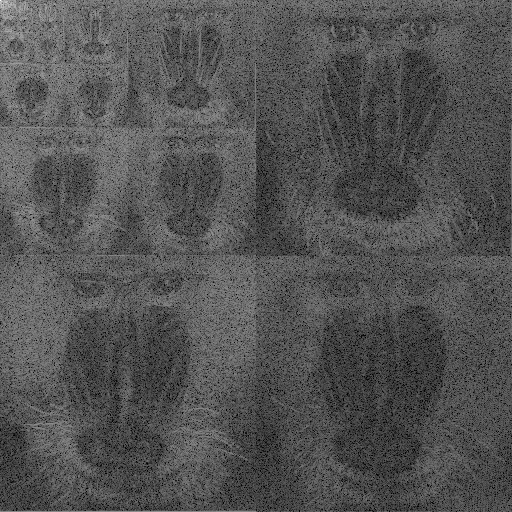

In [23]:
img = Gray.(testimage("mandrill"))
rawImg = convert(Array{Float32}, img)
println("Original Image");
display(img)
save("writeup/images/mandrill_gray.png", Gray.(rawImg))
wt = wavelet(WT.cdf97, WT.Lifting)
dwt!(rawImg, wt)
println("Wavelet Transform");
linDWTclip = clamp.(rawImg, 0, 1)
display(Gray.(linDWTclip))
save("writeup/images/mandrill_linDWT.png", Gray.(linDWTclip))
println("Log-amplitude Wavelet Transform");
logAbs = log2.(abs.(rawImg))
maxLog = maximum(logAbs)
minLog = minimum(logAbs)/2
logAbs = clamp.((logAbs .- minLog)./(maxLog - minLog), 0, 1)
display(Gray.(logAbs))
save("writeup/images/mandrill_logDWT.png", Gray.(logAbs))

# SVD of Wavelet Transform

In [11]:
Am = convert.(Float32, Gray.(testimage("mandrill")))
Ap = convert.(Float32, Gray.(testimage("peppers")))
Al = convert.(Float32, Gray.(testimage("lighthouse")[:,128:639]))
Ab = convert.(Float32, Gray.(testimage("monarch_color")[:,155:666]))
Aa = convert.(Float32, Gray.(testimage("airplaneF16")))
Fm = svd(Am, full=true)
Fp = svd(Ap, full=true)
Fl = svd(Al, full=true)
Fb = svd(Ab, full=true)
Fa = svd(Aa, full=true)
Fm.S ./= maximum(Fm.S)
Fp.S ./= maximum(Fp.S)
Fl.S ./= maximum(Fl.S)
Fb.S ./= maximum(Fb.S)
Fa.S ./= maximum(Fa.S)
display(plot([Fm.S Fp.S Fl.S Fb.S Fa.S], yaxis=:log, ylabel = L"\sigma_k/\sigma_1", xlabel = L"k", legend=:bottomleft, dpi = 300, size = (400, 300), framestyle = :box, labels=["mandrill" "peppers" "lighthouse" "monarch" "airplane"]))
savefig("writeup/images/mandrill_SVD.png")